In [32]:
import os
import discoursegraphs as dg
from discoursegraphs.readwrite.tree import t, word_wrap_tree
from discoursegraphs.readwrite.rst.rs3.rs3tree import n, s

from discoursegraphs.readwrite.rst.dis.common import (
    DisFile,
    get_child_types, get_edu_text, get_node_type, get_relation_type, get_tree_type,
    NODE_TYPES, SUBTREE_TYPES)

ROOT = 'Root'
NUC = 'Nucleus'
SAT = 'Satellite'

In [3]:
dis_1115_str = """
( Root (span 1 7)
  ( Nucleus (span 1 4) (rel2par span)
    ( Nucleus (span 1 3) (rel2par span)
      ( Satellite (leaf 1) (rel2par attribution) (text _!USX Corp. said_!) )
      ( Nucleus (span 2 3) (rel2par span)
        ( Nucleus (leaf 2) (rel2par span) (text _!it delayed the proposed initial public offering of common stock of RMI Titanium Co._!) )
        ( Satellite (leaf 3) (rel2par consequence-n) (text _!because of market conditions.<P>_!) )
      )
    )
    ( Satellite (leaf 4) (rel2par elaboration-additional) (text _!RMI Titanium is owned jointly by USX and Quantum Chemical Corp.<P>_!) )
  )
  ( Satellite (span 5 7) (rel2par elaboration-additional)
    ( Nucleus (span 5 6) (rel2par Same-Unit)
      ( Nucleus (leaf 5) (rel2par span) (text _!USX,_!) )
      ( Satellite (leaf 6) (rel2par elaboration-additional-e) (text _!which hadn't set a date for the offering,_!) )
    )
    ( Nucleus (leaf 7) (rel2par Same-Unit) (text _!didn't disclose any timetable for the offering._!) )
  )
)
"""

In [4]:
expected = t('elaboration-additional', [ # 1-7
    ('N', [ # 1-4
        ('elaboration-additional', [
            ('N', [ # 1-3
                ('attribution', [
                    s(['USX Corp. said']), # 1
                    ('N', [ # 2-3
                        ('consequence-n', [
                            n(['it delayed the proposed initial public offering of common stock of RMI Titanium Co.']), # 2
                            s(['because of market conditions.']) # 3
                        ])
                        
                    ])
                ])
            ]),
            s(['RMI Titanium is owned jointly by USX and Quantum Chemical Corp.']) # 4
        ])
    ]),
    ('S', [ # 5-7
        ('Same-Unit', [
            ('N', [ # 5-6
                ('elaboration-additional-e', [ 
                    n(['USX,']), # 5
                    s(["which hadn't set a date for the offering,"]) # 6
                ])
            ]),
            n(["didn't disclose any timetable for the offering."]) # 7
        ])
    ])
])

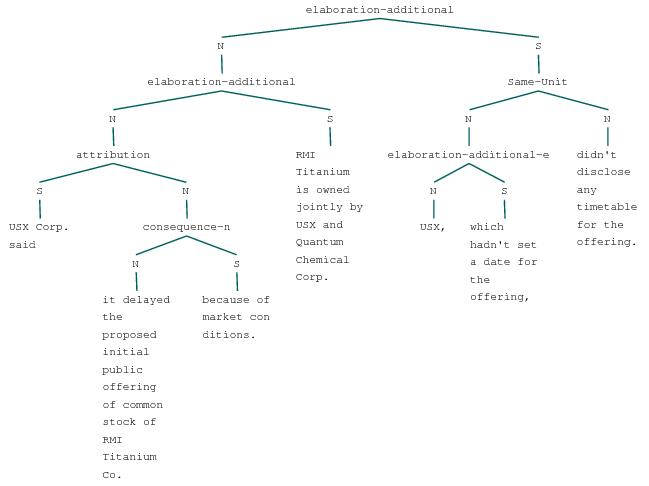

In [5]:
word_wrap_tree(expected, width=10)

In [6]:
dis_1115 = DisFile.fromstring(dis_1115_str)

In [7]:
# get_child_types, get_edu_text, get_node_type, get_relation_type, get_tree_type,

Root
3
defaultdict(<type 'list'>, {'Satellite': [0]})


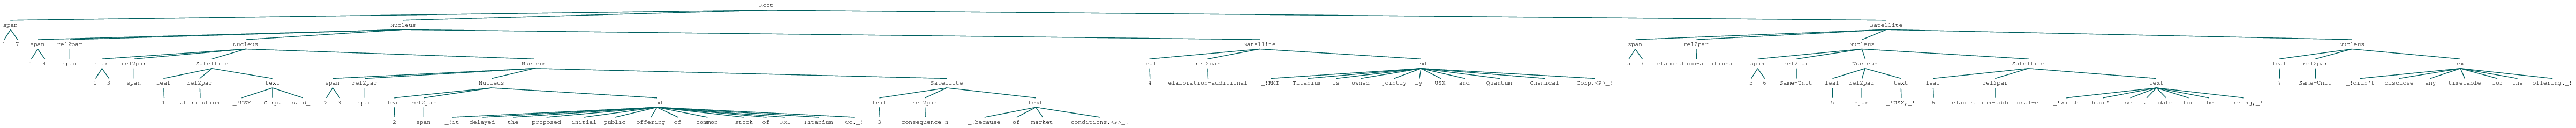

In [8]:
print dis_1115.tree.label()
print len(dis_1115.tree)
print get_child_types(dis_1115.tree[2:])
dis_1115.tree

In [9]:
type(dis_1115.tree)

nltk.tree.ParentedTree

span
2


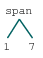

In [10]:
index = 0
print dis_1115.tree[index].label()
print len(dis_1115.tree[index])
dis_1115.tree[index]

Nucleus
4
defaultdict(<type 'list'>, {'Satellite': [1], 'Nucleus': [0]})


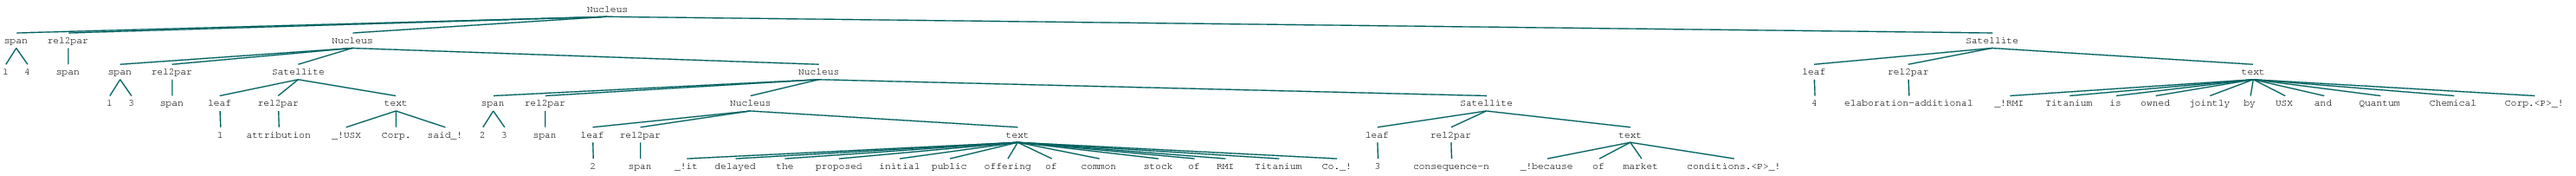

In [11]:
index = 1
print dis_1115.tree[index].label()
print len(dis_1115.tree[index])
print get_child_types(dis_1115.tree[index][2:])
dis_1115.tree[index]

4
span


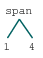

In [12]:
nuc = dis_1115.tree[1]
print len(nuc)
print nuc[0].label()
nuc[0]

1
rel2par


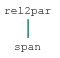

In [13]:
index = 1
print len(nuc[index])
print nuc[index].label()
nuc[index]

4
Nucleus


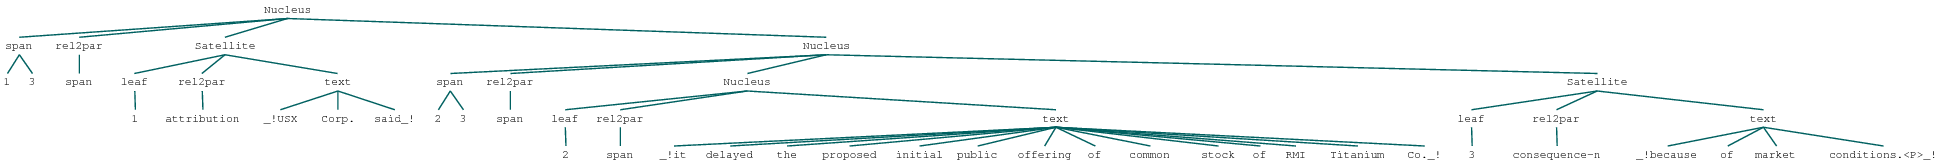

In [14]:
index = 2
print len(nuc[index])
print nuc[index].label()
nuc[index]

3
Satellite


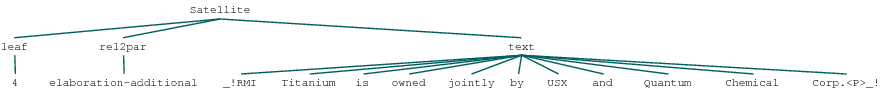

In [15]:
index = 3
print len(nuc[index])
print nuc[index].label()
nuc[index]

Satellite
4


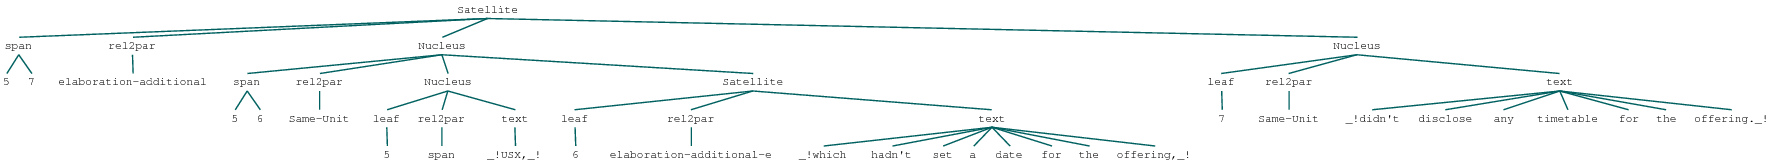

In [16]:
print dis_1115.tree[2].label()
print len(dis_1115.tree[2])
dis_1115.tree[2]

In [17]:
def n_wrap(tree):
    return t('N', [tree])

def s_wrap(tree):
    return t('S', [tree])

In [18]:
def get_element_wrapper(dis_tree):
    label = dis_tree.label()
    return n_wrap if label == NUC else s_wrap

In [19]:
def leaf2tree(dis_subtree):
    assert get_tree_type(dis_subtree) in SUBTREE_TYPES
    assert get_node_type(dis_subtree) == 'leaf'

    elem_wrapper = get_element_wrapper(dis_subtree)
    return elem_wrapper([get_edu_text(dis_subtree[2])])

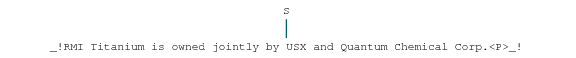

In [20]:
leaf2tree(nuc[3])

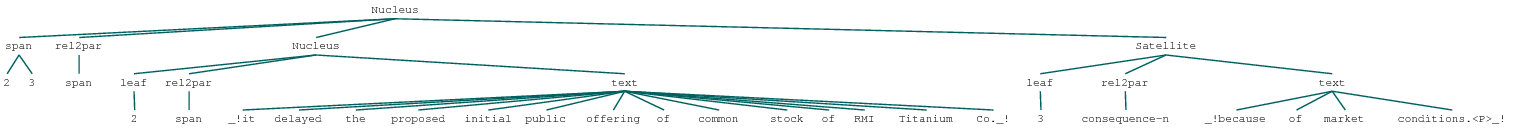

In [21]:
simple_nucsat_tree = nuc[2][3]
simple_nucsat_tree

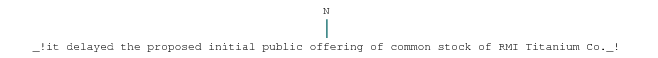

In [22]:
leaf2tree(simple_nucsat_tree[2])

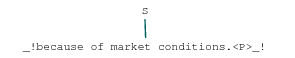

In [33]:
leaf2tree(simple_nucsat_tree[3])

In [37]:
dis2tree(dis_1115.tree)

AssertionError: 

In [44]:
def is_root(dis_tree):
    return get_tree_type(dis_tree) == ROOT

In [49]:
def get_wrapped_tree(dis_tree, rst_tree, wrap_tree=False):
    if wrap_tree:
        tree_wrapper = get_element_wrapper(dis_tree)
        return tree_wrapper(rst_tree)
    return rst_tree

In [50]:
def dis2tree(dis_tree, wrap_tree=False):
    assert get_tree_type(dis_tree) in SUBTREE_TYPES
    if get_node_type(dis_tree) == 'leaf':
        return leaf2tree(dis_tree)
    
    if is_root(dis_tree):
        children = dis_tree[1:]
    else:
        children = dis_tree[2:]

    child_types = get_child_types(children)    
    if len(child_types) == 1: # this is a multinuc relation
        assert NUC in child_types
        assert len(child_types[NUC]) > 1
        
        subtrees = [dis2tree(children[child_id], wrap_tree=True) for child_id in child_types[NUC]]
        
        # all subtrees of a multinuc have the same relation, so we can just read it from the first one
        reltype = get_relation_type(children[0])      
        
    else: # this is a nucleus-satellite relation
        assert len(child_types) == 2
        assert NUC in child_types and SAT in child_types
        assert len(child_types[NUC]) == 1 and len(child_types[SAT]) == 1
        
        nuc_child_id = child_types[NUC][0]
        nuc_subtree = dis2tree(children[nuc_child_id], wrap_tree=True)

        sat_child_id = child_types[SAT][0]
        sat_child = children[sat_child_id]
        sat_subtree = dis2tree(sat_child, wrap_tree=True)

        # determine order of subtrees
        if nuc_child_id < sat_child_id:
            subtrees = [nuc_subtree, sat_subtree]
        else:
            subtrees = [sat_subtree, nuc_subtree]
        
        # the relation type is only stored in the satellite
        reltype = get_relation_type(sat_child)

    rst_tree = t(reltype, subtrees)
    return get_wrapped_tree(dis_tree, rst_tree, wrap_tree=wrap_tree)

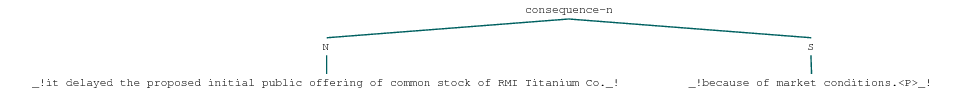

In [51]:
dis2tree(simple_nucsat_tree)

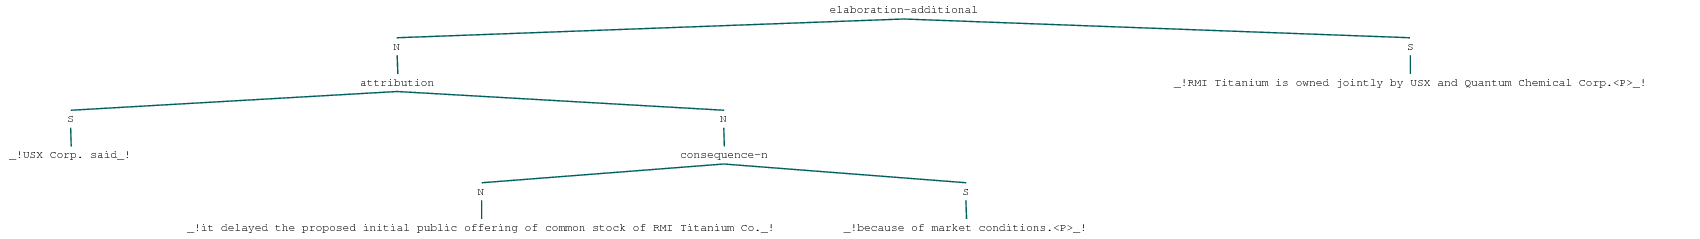

In [52]:
dis2tree(nuc)

In [27]:
# TODO: for debugging: function to extract all EDUs -> convert to n() or s(); store in leaves dict

In [28]:
codra_str = """( Root (span 1 43)
  ( Nucleus (span 1 4) (rel2par span)
    ( Nucleus (span 1 3) (rel2par span)
      ( Nucleus (span 1 2) (rel2par Same-Unit)
        ( Nucleus (leaf 1) (rel2par span) (text _!Henryk Szeryng_!) )
        ( Satellite (leaf 2) (rel2par Elaboration) (text _!( 22 September 1918 - 8 March 1988 )_!) )
       )
      ( Nucleus (leaf 3) (rel2par Same-Unit) (text _!was a violin virtuoso of Polish and Jewish heritage ._!) )
    )
    ( Satellite (leaf 4) (rel2par Elaboration) (text _!He was born in Zelazowa Wola , Poland ._!) )
  )
  ( Satellite (span 5 43) (rel2par Summary)
    ( Nucleus (span 5 8) (rel2par span)
      ( Nucleus (span 5 6) (rel2par Joint)
        ( Nucleus (leaf 5) (rel2par span) (text _!Henryk started piano and harmony training with his mother_!) )
        ( Satellite (leaf 6) (rel2par Elaboration) (text _!when he was 5 ,_!) )
       )
      ( Nucleus (span 7 8) (rel2par Joint)
        ( Nucleus (leaf 7) (rel2par span) (text _!and at age 7 turned to the violin ,_!) )
        ( Satellite (leaf 8) (rel2par Elaboration) (text _!receiving instruction from Maurice Frenkel ._!) )
       )
    )
    ( Satellite (span 9 43) (rel2par Elaboration)
      ( Nucleus (span 9 13) (rel2par span)
        ( Nucleus (span 9 10) (rel2par Same-Unit)
          ( Nucleus (leaf 9) (rel2par span) (text _!After studies with Carl Flesch in Berlin_!) )
          ( Satellite (leaf 10) (rel2par Elaboration) (text _!( 1929-32 ) ,_!) )
         )
        ( Nucleus (span 11 13) (rel2par Same-Unit)
          ( Nucleus (span 11 12) (rel2par span)
            ( Nucleus (leaf 11) (rel2par span) (text _!he went to Paris_!) )
            ( Satellite (leaf 12) (rel2par Enablement) (text _!to continue his training with Jacques Thibaud at the Conservatory ,_!) )
           )
          ( Satellite (leaf 13) (rel2par Evaluation) (text _!graduating with a premier prix in 1937 ._!) )
         )
      )
      ( Satellite (span 14 43) (rel2par Elaboration)
        ( Nucleus (span 14 28) (rel2par span)
          ( Nucleus (span 14 20) (rel2par span)
            ( Nucleus (span 14 15) (rel2par span)
              ( Nucleus (leaf 14) (rel2par span) (text _!He made his solo debut in 1933_!) )
              ( Satellite (leaf 15) (rel2par Elaboration) (text _!playing the Brahms Violin Concerto ._!) )
            )
            ( Satellite (span 16 20) (rel2par Elaboration)
              ( Nucleus (span 16 17) (rel2par Joint)
                ( Nucleus (leaf 16) (rel2par span) (text _!From 1933 to 1939_!) )
                ( Satellite (leaf 17) (rel2par Elaboration) (text _!he studied composition in Paris with Nadia Boulanger ,_!) )
               )
              ( Nucleus (span 18 20) (rel2par Joint)
                ( Nucleus (span 18 19) (rel2par Same-Unit)
                  ( Nucleus (leaf 18) (rel2par span) (text _!and during World War II he worked as an interpreter for the Polish government in exile_!) )
                  ( Satellite (leaf 19) (rel2par Elaboration) (text _!( Szeryng was fluent in seven languages )_!) )
                 )
                ( Nucleus (leaf 20) (rel2par Same-Unit) (text _!and gave concerts for Allied troops all over the world ._!) )
               )
            )
          )
          ( Satellite (span 21 28) (rel2par Explanation)
            ( Nucleus (span 21 25) (rel2par span)
              ( Nucleus (span 21 23) (rel2par span)
                ( Satellite (leaf 21) (rel2par Background) (text _!During one of these concerts in Mexico City_!) )
                ( Nucleus (span 22 23) (rel2par span)
                  ( Nucleus (leaf 22) (rel2par span) (text _!he received an offer_!) )
                  ( Satellite (leaf 23) (rel2par Elaboration) (text _!to take over the string department of the university there ._!) )
                 )
              )
              ( Satellite (span 24 25) (rel2par Elaboration)
                ( Satellite (leaf 24) (rel2par Background) (text _!In 1946 ,_!) )
                ( Nucleus (leaf 25) (rel2par span) (text _!he became a naturalized citizen of Mexico ._!) )
              )
            )
            ( Satellite (span 26 28) (rel2par Elaboration)
              ( Nucleus (leaf 26) (rel2par span) (text _!Szeryng subsequently focused on teaching before resuming his concert career in 1954 ._!) )
              ( Satellite (span 27 28) (rel2par Elaboration)
                ( Nucleus (leaf 27) (rel2par Joint) (text _!His debut in New York City brought him great acclaim ,_!) )
                ( Nucleus (leaf 28) (rel2par Joint) (text _!and he toured widely for the rest of his life ._!) )
              )
            )
          )
        )
        ( Satellite (span 29 43) (rel2par Elaboration)
          ( Nucleus (span 29 32) (rel2par Joint)
            ( Nucleus (leaf 29) (rel2par span) (text _!He died in Kassel ._!) )
            ( Satellite (span 30 32) (rel2par Explanation)
              ( Nucleus (span 30 31) (rel2par Joint)
                ( Nucleus (leaf 30) (rel2par span) (text _!Szeryng made a number of recordings ,_!) )
                ( Satellite (leaf 31) (rel2par Elaboration) (text _!including two of the complete sonatas and partitas for violin by Johann Sebastian Bach ,_!) )
               )
              ( Nucleus (leaf 32) (rel2par Joint) (text _!and several of sonatas of Beethoven and Brahms with the pianist Arthur Rubinstein ._!) )
            )
          )
          ( Nucleus (span 33 43) (rel2par Joint)
            ( Nucleus (span 33 37) (rel2par span)
              ( Nucleus (span 33 34) (rel2par span)
                ( Nucleus (leaf 33) (rel2par span) (text _!He also composed ;_!) )
                ( Satellite (leaf 34) (rel2par Elaboration) (text _!his works include a number of violin concertos and pieces of chamber music ._!) )
              )
              ( Satellite (span 35 37) (rel2par Elaboration)
                ( Nucleus (leaf 35) (rel2par span) (text _!He owned the Del Gesu \\\" Le Duc \\\" , the Stradivarius \\\" King David \\\" as well as the Messiah Strad copy_!) )
                ( Satellite (span 36 37) (rel2par Manner-Means)
                  ( Nucleus (leaf 36) (rel2par span) (text _!by Jean-Baptiste Vuillaume_!) )
                  ( Satellite (leaf 37) (rel2par Elaboration) (text _!which he gave to Prince Rainier III of Monaco ._!) )
                 )
              )
            )
            ( Satellite (span 38 43) (rel2par Elaboration)
              ( Nucleus (span 38 42) (rel2par Same-Unit)
                ( Nucleus (leaf 38) (rel2par span) (text _!The \\\" Le Duc \\\" was the instrument_!) )
                ( Satellite (span 39 42) (rel2par Elaboration)
                  ( Nucleus (span 39 40) (rel2par Contrast)
                    ( Nucleus (leaf 39) (rel2par Joint) (text _!on which he performed_!) )
                    ( Nucleus (leaf 40) (rel2par Joint) (text _!and recorded mostly ,_!) )
                   )
                  ( Nucleus (span 41 42) (rel2par Contrast)
                    ( Nucleus (leaf 41) (rel2par span) (text _!while the latter_!) )
                    ( Satellite (leaf 42) (rel2par Elaboration) (text _!( \\\" King David \\\" Strad )_!) )
                   )
                 )
               )
              ( Nucleus (leaf 43) (rel2par Same-Unit) (text _!was donated to the State of Israel ._!) )
            )
          )
        )
      )
    )
  )
)
"""

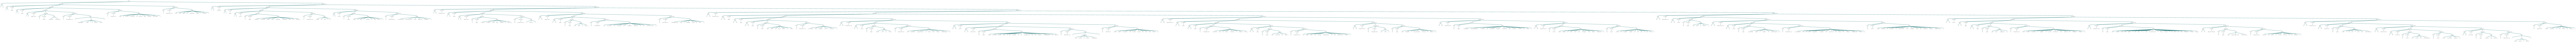

In [53]:
codra_tree = DisFile.fromstring(codra_str).tree
codra_tree

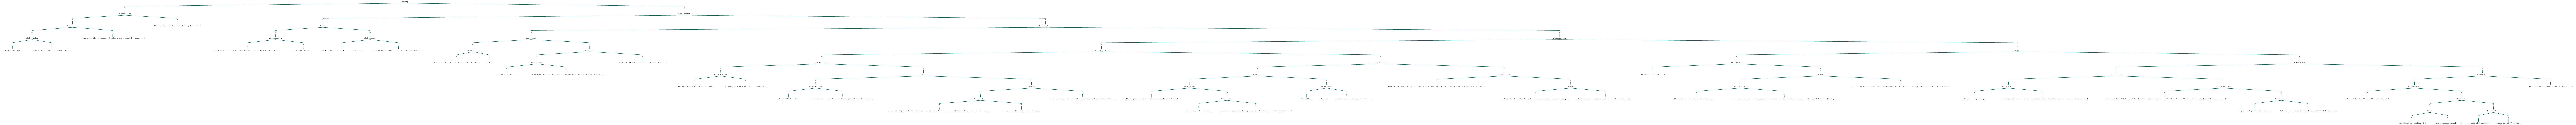

In [54]:
dis2tree(codra_tree)